# Vehicle Price Forecaster

## 1. Introduction

Welcome to the Vehicle Price Forecaster! This utility seeks to advise clients on how much their customer's vehicle may be worth before putting it up for trade-in. In its current state, users will input information about the vehicle in the provided user interface located at the bottom of the Jupyter Notebook page. 
## 2. Problem Definition

The prime problem this seeks to resolve is to ease the burden placed on employees on valuing vehicle trade-ins for a wide selection of vehicles. 
## 3. Data

The data this prototype will use contains 852122 car records. 

The data was obtained from Kaggle and can be found using the following link:
    
    https://www.kaggle.com/datasets/harikrishnareddyb/used-car-price-predictions

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import datetime
from ipywidgets import interact, interactive, fixed, interact_manual, Box
import ipywidgets as widgets

In [2]:
# Importing the data
df_car_listings = pd.read_csv("data/true_car_listings.csv")
df_car_listings_copy = df_car_listings.copy()

df_car_listings.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [3]:
# Drop "Vin" column as it is unecessary for model.
df_car_listings_modified = df_car_listings.drop(["Vin"], axis=1)

In [4]:
# Length of dataset.
len(df_car_listings)

852122

In [5]:
# Reflect changes made to dataset.
df_car_listings_modified

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,El Paso,TX,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,Acura,ILXAutomatic
...,...,...,...,...,...,...,...
852117,63215,2017,9,Culver City,CA,Volvo,S90T6
852118,72260,2017,3201,Englewood,NJ,Volvo,XC90T6
852119,55999,2016,28941,Fort Collins,CO,Volvo,XC90AWD
852120,60240,2017,3005,San Leandro,CA,Volvo,V90


# Visualizations

- The following visualizations reflect important features of the data, namely:
    - The scatterplot shows how the value of a vehicle degrades as mileage increases. The red line highlights the average value
    of the first 1000 vehicles within the dataset. 
    - The histogram reflects where in the price range the majority of vehicles fall under.
        - Note: Histogram shown is cropped and exludes values that exceed the vehicle price range. 

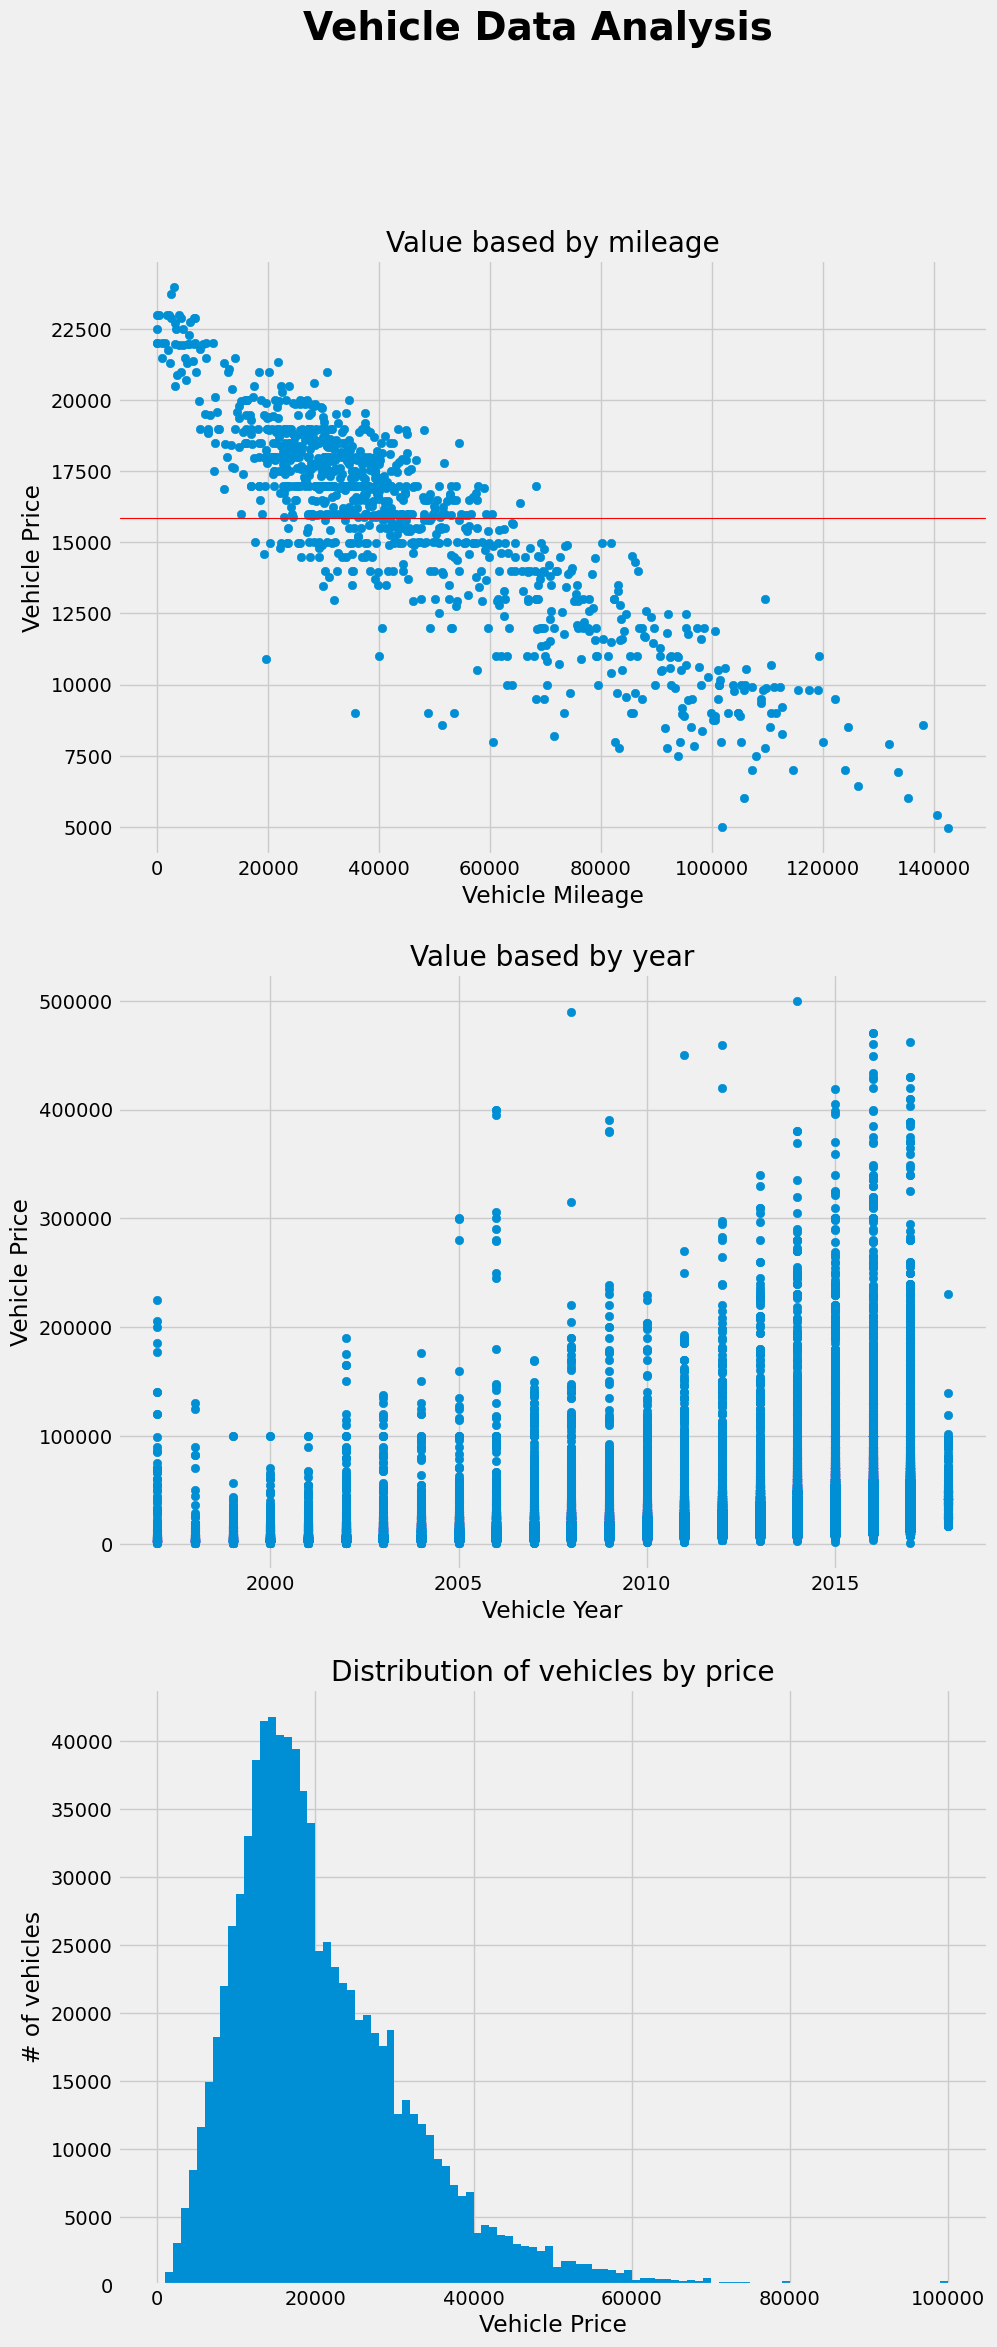

In [6]:
# Analyzing the data
plt.style.use('fivethirtyeight')
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(10,25))
fig.suptitle("Vehicle Data Analysis", fontsize=28, fontweight="bold")

# Plot and customize ax2 (scatter plot) 
ax0.scatter(df_car_listings["Mileage"][:1000], df_car_listings["Price"][:1000])
ax0.title.set_text("Value based by mileage")
ax0.set_xlabel("Vehicle Mileage")
ax0.set_ylabel("Vehicle Price")
mean = df_car_listings["Price"][:1000].mean()
ax0.axhline(mean, color='red', lw="0.8")

# Plot and customize ax3 (histogram)
ax1.scatter(df_car_listings["Year"], df_car_listings["Price"])
ax1.title.set_text("Value based by year")
ax1.set_xlabel("Vehicle Year")
ax1.set_ylabel("Vehicle Price")
#plt.xlim(1995, 2019)

# Plot and customize ax2 (histogram)
ax2.hist(df_car_listings["Price"], bins=100, range=(0, 100000))
ax2.title.set_text("Distribution of vehicles by price")
ax2.set_xlabel("Vehicle Price")
ax2.set_ylabel("# of vehicles");

# Preparing the Data for the Model

1. First step is to resolve any Null/NaN values in our data.
2. Convert all non-numerical data to be numerical.
3. Split the data into train and test sets.

### 1. Resolving NaN/Null values

In [7]:
# Count total number of null/NaN values across entire dataset
df_car_listings.isnull().sum().sum()

0

There are no NaN/Null values within the dataset. No futher action is required for step 1.

### 2. Convert Non-Numerical data types to be Numerical.
    - For this section a LabelEncoder is used to transform all objects into ints, a dictionary is used to map labels with 
    their encoded numerical values.
    - When making predictions dictionary will be used to map new predicted vehicle to original dataset numerical values. 

In [8]:
# View datatypes for given dataset
df_car_listings_modified.head()
df_car_listings_modified.dtypes

Price       int64
Year        int64
Mileage     int64
City       object
State      object
Make       object
Model      object
dtype: object

There are 4 Datatypes that are non-numerical and will need to be resolved.

In [9]:
# Create a LabelEncoder for each non-numerical feature 
# Encode categorical labels as ints
cityEncoder = LabelEncoder()
stateEncoder = LabelEncoder()
makeEncoder = LabelEncoder()
modelEncoder = LabelEncoder()

df_car_listings_modified["City"] = cityEncoder.fit_transform(df_car_listings_modified["City"]) 
df_car_listings_modified["State"] = stateEncoder.fit_transform(df_car_listings_modified["State"]) 
df_car_listings_modified["Make"] = makeEncoder.fit_transform(df_car_listings_modified["Make"]) 
df_car_listings_modified["Model"] = modelEncoder.fit_transform(df_car_listings_modified["Model"]) 

In [10]:
# Create dictionaries for each encoded categorical label. 
cityMapping = dict(zip(cityEncoder.classes_, range(len(cityEncoder.classes_))))
stateMapping = dict(zip(stateEncoder.classes_, range(len(stateEncoder.classes_))))
makeMapping = dict(zip(makeEncoder.classes_, range(len(makeEncoder.classes_))))
modelMapping = dict(zip(modelEncoder.classes_, range(len(modelEncoder.classes_))))

In [11]:
# Reflect encoded values are working.
df_car_listings_modified.head()

,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,646,49,1,1194
1,10888,2013,19606,1260,39,1,1193
2,8995,2013,48851,646,49,1,1194
3,10999,2014,39922,2490,6,1,1193
4,14799,2016,22142,1231,50,1,1196


In [12]:
df_car_listings_modified.dtypes

Price      int64
Year       int64
Mileage    int64
City       int32
State      int32
Make       int32
Model      int32
dtype: object

After using an Encoder, all datatypes are now numerical and can be split and fit for our model. 

### 3. Split the data

Data will be split into train and test sets. The current ratio is 80/20 (train/test).

In [13]:
# Splitting the data with a 80(train)/20(test) ratio
X = df_car_listings_modified.drop("Price", axis=1)
y = df_car_listings_modified["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creating the Model

- A RandomForestRegressor model will be used on the data.
- The data will be fit to the model to train.
- A function called 'scores' will be created to measure accuracy.
    - The show_scores function will measure R^2 and Mean Absolute Error for all sets.
- Hyperparameters will be fine tuned for better accuracy. 
- Predictions can be made.

In [14]:
%%time
# Creating the model and fitting the data to the model.
forecast_model = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=100)
forecast_model.fit(X_train,  y_train)

CPU times: total: 10min 48s
Wall time: 36.9 s


RandomForestRegressor(n_jobs=-1, random_state=42)

### Accuracy Metric 

In [15]:
def show_scores(forecast_model):
    train_preds = forecast_model.predict(X_train)
    test_preds = forecast_model.predict(X_test)
    scores = {
        "Training MAE": mean_absolute_error(y_train, train_preds),
        "Test MAE": mean_absolute_error(y_test, test_preds),
        "Training R^2": r2_score(y_train, train_preds),
        "Test R^2": r2_score(y_test, test_preds)
    }
    return scores

In [16]:
show_scores(forecast_model)

{'Training MAE': 842.9293848640515,
 'Test MAE': 2252.8852022079896,
 'Training R^2': 0.9856265552406323,
 'Test R^2': 0.8967923940065348}

In [17]:
preds = forecast_model.predict(X_test)
preds

array([16497.14, 13475.27, 22633.46, ..., 18545.99, 32781.99, 23837.92])

In [18]:
df_preds = pd.DataFrame()
df_preds['Price Actual'] = y_test
df_preds['Price Predictions'] = preds
df_preds.head()

,Price Actual,Price Predictions
729827,17300,16497.14
825968,12615,13475.27
353439,22995,22633.46
477184,53692,50249.73
282908,20900,21135.08


# Making Predictions!
- At the bottom of the page there will be a simple user interface for you to enter in desired details
 about the vehicle. Once the predict button is pressed, the cell will output the estimated value as well
 as a histogram visualizing the distribution of vehicles value compared with the user created one. 
- Please rerun the last cell after every prediction, graphs currently are not replaced and will duplicate.

In [19]:
cityList = cityEncoder.inverse_transform(df_car_listings_modified['City'].unique().tolist())
stateList = stateEncoder.inverse_transform(df_car_listings_modified['State'].unique().tolist())
makeList = makeEncoder.inverse_transform(df_car_listings_modified['Make'].unique().tolist())
modelList = modelEncoder.inverse_transform(df_car_listings_modified['Model'].unique().tolist())

In [20]:
# Creating widgets for UI
yearText = widgets.IntText(value=None, description='Year', disabled=False)
mileageText = widgets.IntText(value=0, description='Mileage', disabled=False)
cityDrop = widgets.Dropdown(options=cityList, description='City:', disabled=False)
stateDrop = widgets.Dropdown(options=stateList, description='State:', disabled=False)
makeDrop = widgets.Dropdown(options=makeList, description='Make:', disabled=False)
modelDrop = widgets.Dropdown(options=modelList, description='Model:', disabled=False)
predictButton = widgets.Button(description="Predict!")
button_output = widgets.Label('Enter values and press Predict!')

In [21]:
# On click a prediction is made by the model, a histogram will display distribution of cars by their respective price. With
# a vertical line highlighting predicted value of given vehicle.
def on_click_predict(b):
    car_info = [yearText.value, mileageText.value, cityMapping[cityDrop.value], stateMapping[stateDrop.value], 
                makeMapping[makeDrop.value], modelMapping[modelDrop.value]]
    
    df_predict = pd.DataFrame(columns = ['Year', 'Mileage', 'City', 'State', 'Make', 'Model'])
    df_predict.loc[len(df_predict)] = car_info
    prediction = forecast_model.predict(df_predict)
    create_hist(prediction)
    button_output.value= "Predicted value of your vehicle: $" + str(float(f'{prediction[0]:.2f}'))
predictButton.on_click(on_click_predict)

In [22]:
def create_hist(prediction):
    visual_hist = plt.hist(df_car_listings["Price"], color = "skyblue", bins=100, range=(0, 100000))
    plt.title("Distribution of Vehicles by Price")
    plt.xlabel("Price"), plt.ylabel("Count of vehicles")
    visual_hist = plt.axvline(prediction, color="red", ls="--", lw='0.8')

In [23]:
# Container for widgets
vb = widgets.VBox([yearText, mileageText, cityDrop, stateDrop, makeDrop, modelDrop, button_output, predictButton])

# Displays widgets
display(vb, clear=True)